Suppose we have one output and two inpute nodes, such that 

$$
\{x_1,x_2\} \rightarrow y
$$

Where we use the function $z(f(x))$ to convert the features into $y$. Let's have the following mapping:

| $x_1\ x_2$ | y |
|---|---|
|$00$|0|
|$01$|0|
|$10$|1|
|$11$|0|

Suppose we have $10$ random examples of this mapping:

In [49]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(2,size=(2,10))
y = np.empty((0,0))
for i in x[0,:]:
    if(i==2):
        y = np.append(y,1)
    else:
        y = np.append(y,0)
x = x.reshape(x.shape[0],x.shape[1])
y = y.reshape(1,y.shape[0])

In [79]:
print(x.shape)
print(y.shape)
print(x[:,0]) #Training example 1

(2, 10)
(1, 10)
[0 1]


If we want to implement a neural network to map this properly, we begin by setting up the architecture of forward propagation, which is, firstly:

$$
f(x_i) = w_ix_i + b_i
$$
where $w_i,\ b_i$ are randomly set, for every input feature $i$ in the layer.

In [51]:
def initialize_parameters(layer_dims):
    """
    Function: initialize_parameters
    The function creates $n$ weights & biases per layer, 
    where $n$ is the number of nodes in layer $l$. 
    The list of weights & biases are stored in `parameters`
    """
    parameters = {}
    L = len(layer_dims) #Number of layers in the network
    
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*.01
        parameters['b'+str(l)] = np.random.randn(layer_dims[l],1)
        
        assert(parameters['W'+str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters['b'+str(l)].shape == (layer_dims[l], 1))
        
        
    return parameters

In [52]:
def linear_forward(X, W, b):
    """
    Function: linear_forward
    Computes f(x_i) = w_ix_i + b_i for all nodes $i$ in a single layer
    """    
    #Calculate Z in Neuron
    Z = np.dot(W, X) + b

    assert(Z.shape == (W.shape[0], X.shape[1]))
    
    #Save cache for backward propogation    
    cache = (X, W, b)
    
    return Z, cache

After that, we reach the output layer, for which we use the `activation function` $z(f(x_i)$ such that

$$
z(f(x_i)) = \frac{1}{1+e^{-f(x_i)}}
$$

From there, we estimate that the result $y$ is $1$ if $z(f(x_i))>0.5$; otherwise, $y=0$.


In [53]:
def sigmoid(f):
    return 1/(1+np.exp(-f))

def activation_forward(A_prev, W, b):
    """
    Calculates z(f(x_i)) = (1/(1+e^{-f(x_i)}))
    For a single layer
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    A = sigmoid(Z)
        
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, Z)
    return A, cache

Placing it all together, we have the forward propagation function

In [54]:
def forward_propogation(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
       
    for l in range(1, L):
        A_prev = A
        A, cache = activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)])
        caches.append(cache)
    
    #Compute final prediction
    AL, cache = activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)])
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    
    return AL, caches

# Cost Function

Now, we must compute the cost function, which is calculated by
$$
J = (-1/m) * (\sum_{i}^m y^{i} log(PredictionX^{i}) + (1-y^i)log(1-PredictionX^i),
$$
where $m=1000$, $y^i$ is our labelled data, and $predictionX^i$ is our neural network prediction, for all training examples $i$ ($i=2$).


In [55]:
def compute_cost(A_final, Y):
    """
    #Cost function
    def compute_cost()

    Implement loss function for binary classifcation:
    -1/m sum(Ylog(A) + (1-Y)log(1-A))
    """
    m = Y.shape[1]
    
    
    cost = -1/m * np.sum(Y*np.log(A_final) + (1-Y)*np.log(1-A_final))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost


# Backpropagation

Now, we must modify our parameters, $w_i,b_i$ to increase the accuracy of our predictions, $PredictionX^i$. To modify the functions, we take the derivatives of $a_l$ with respect to $w_i,b_i$, and then store them as `gradients`

In [56]:
"""
#Backward propogation
def  linear_backward()
calculate gradients (derivatives) of a layer,i, 
"""

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    
    return dA_prev, dW, db

In [57]:
"""
#Backward propogation
activation_backward(dA, cache, activation):
Calculate derivatives of activation function & Z for a given layer, i
"""

def activation_backward(dA, cache):
    
    linear_cache, activation_cache = cache #(A, W, b) & (Z)

    s = sigmoid(activation_cache)
    dZ = dA* s*(1-s)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)


    
    return dA_prev, dW, db

You can clearly see that there's a resemblance in structure to forward propagation(that's because there is). You might be able to guess that we place these two functions together to create a general function for back-propagation: 

In [58]:
"""
#Backward propogation
combine activation & linear backwardpropogation gradients across all layers
"""

def backward_propogation(AL, Y, caches):
    grads = {}
    L = len(caches) #Number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    #Derivative of loss function in compute_cost()
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    #Compute sigmoid derivative
    current_cache = caches[L-1]
    grads["dA"+str(L-1)], grads["dW"+str(L)],grads["db"+str(L)] = activation_backward(dAL, current_cache)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA"+str(l+1)],current_cache)
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)] = db_temp
        
    return grads

# Gradient Descent

Finally, we apply gradient descent to iteratively execute these steps (forward-propagation, cost measurement, backward-propagation).

In [59]:

"""
#Gradient Descent
def update_parameters()

modify the weights & biases based on backward_propogation
"""

def update_parameters(parameters ,grads, learning_rate):
    
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate *grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate*grads["db"+str(l+1)]
    return parameters
        

The complete model then becomes a combination of every function we just used

In [66]:
"""
#Neural Network 

Combine all helper functions (forward_propogation, backward_propogation, compute_cost, update_parameters)
To create an L-layer Neural Network
"""

def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations, print_cost = False):
    costs = [] # Keep track of cost to plot later
    
    parameters = initialize_parameters(layer_dims)
    
    
    for i in range(0, num_iterations):
        #Forward prop
        AL,caches = forward_propogation(X,parameters)
        
        #Cost function
        cost = compute_cost(AL,Y)
        
        #Backward prop
        grads = backward_propogation(AL,Y,caches)
        

        parameters = update_parameters(parameters,grads,learning_rate)
        
        if print_cost and i%1 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = "+str(learning_rate))
    plt.show()
    
    return parameters


# Training

How many Neural Networks are we training:  5
List of Learning Rates:  [0.1, 0.015, 1, 0.05, 0.001]
List of Layers dimensions [[2, 1], [2, 1], [2, 1], [2, 1], [2, 1]]
Cost after iteration 0: 1.3205545662225138
Cost after iteration 1: 1.2334125542296481
Cost after iteration 2: 1.1523650113022101
Cost after iteration 3: 1.0772775191148956
Cost after iteration 4: 1.007944837405769
Cost after iteration 5: 0.9441038856062708
Cost after iteration 6: 0.885448350708617
Cost after iteration 7: 0.8316434210473956
Cost after iteration 8: 0.7823394329572297
Cost after iteration 9: 0.7371836175529604


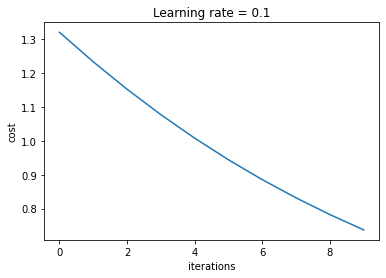

Cost after iteration 0: 0.44263191115332284
Cost after iteration 1: 0.43947488523118355
Cost after iteration 2: 0.43635558186347895
Cost after iteration 3: 0.43327344394547407
Cost after iteration 4: 0.43022792288634504
Cost after iteration 5: 0.42721847851164124
Cost after iteration 6: 0.42424457896475354
Cost after iteration 7: 0.42130570060752526
Cost after iteration 8: 0.41840132792014195
Cost after iteration 9: 0.4155309534004248


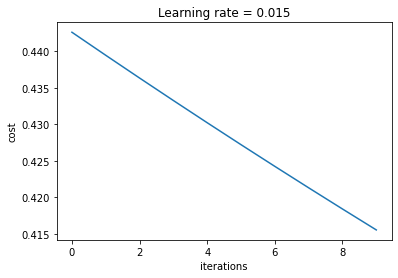

Cost after iteration 0: 0.6266001935209152
Cost after iteration 1: 0.3424688107418953
Cost after iteration 2: 0.23312963437772113
Cost after iteration 3: 0.1775081795015726
Cost after iteration 4: 0.14387405187599053
Cost after iteration 5: 0.12128605825391237
Cost after iteration 6: 0.1050301802219203
Cost after iteration 7: 0.092746528468159
Cost after iteration 8: 0.0831224467065616
Cost after iteration 9: 0.07536884983129899


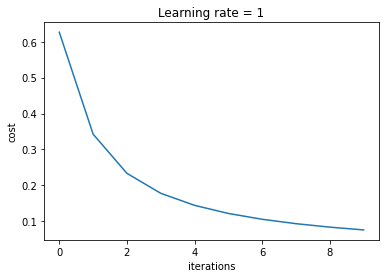

Cost after iteration 0: 1.137004403878004
Cost after iteration 1: 1.0993116811936172
Cost after iteration 2: 1.0630588305429425
Cost after iteration 3: 1.0282177996421207
Cost after iteration 4: 0.9947571822952868
Cost after iteration 5: 0.9626426509954616
Cost after iteration 6: 0.9318373985422327
Cost after iteration 7: 0.9023025783675482
Cost after iteration 8: 0.8739977344311891
Cost after iteration 9: 0.8468812129352559


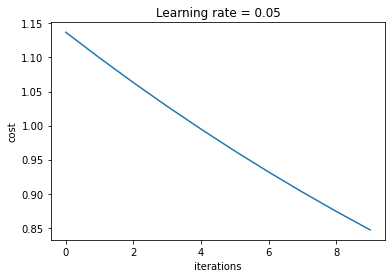

Cost after iteration 0: 1.5695889770691949
Cost after iteration 1: 1.5685557181762506
Cost after iteration 2: 1.5675230547068888
Cost after iteration 3: 1.5664909868133239
Cost after iteration 4: 1.5654595146469648
Cost after iteration 5: 1.5644286383584145
Cost after iteration 6: 1.5633983580974686
Cost after iteration 7: 1.562368674013119
Cost after iteration 8: 1.5613395862535464
Cost after iteration 9: 1.5603110949661256


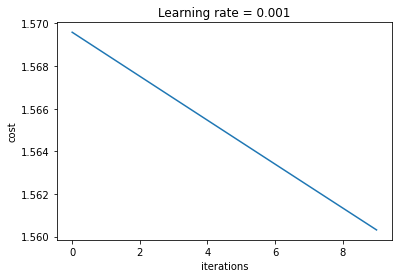

In [74]:
"""
Train a random set of Neural Networks to see best performance
"""
#Constant parameters
input_size = x.shape[0]
output_size = 1
iterations = 10

#Creating of list of hyperparameters to try
#Best performing set of hyperparameters
#list_of_h_layers = [25, 35, 35, 25, 30, 30]
learning_rate_list = [0.1,.015,1,.05,.001] #Best learning rates received so far
layer_list = []


parameters = [] #Stores the trained parameters

#Commented out nested for loop after determining 
#the best hyperparameters
for i in range (len(learning_rate_list)):#Number of neural networks
    layer_dims = [input_size]
#    layer_dims.append(list_of_h_layers[i])
#    for y in range(1): #Number of hidden layers in test case x
#        hidden_layer_size.append(randint(10,40))
#        layer_dims.append(hidden_layer_size[y])
    
    layer_dims.append(output_size)
    #list_of_h_layers.append(hidden_layer_size)#add to the list
    layer_list.append(layer_dims)
#    learning_rate_list.append(randint(1,100)/1000)#Find the best learning rate

print("How many Neural Networks are we training: ", len(learning_rate_list))
print("List of Learning Rates: ", learning_rate_list)
print("List of Layers dimensions", layer_list)


#Test Neural Networks with differing hyperparameters
for i in range(len(layer_list)):
    parameters.append(L_layer_model(x, y, layer_list[i], learning_rate_list[i],iterations, True))

The ideal parameters in this case all converge to

In [75]:
for i in range(1,len(parameters)):
    print(parameters[i])

{'W1': array([[-0.0356833 , -0.01995476]]), 'b1': array([[-0.63878465]])}
{'W1': array([[-1.01884177, -0.57957943]]), 'b1': array([[-1.85213391]])}
{'W1': array([[-0.21496577, -0.12662243]]), 'b1': array([[0.43894846]])}
{'W1': array([[-0.02703545, -0.01516906]]), 'b1': array([[1.34816663]])}


We can use these parameters to predict our variables now that we've trained the functions

In [76]:
#Function to predict with TRAINED NEURAL NETWORKS
def predict(X, Y, parameters):
    m = X.shape[1]
    n = len(parameters) //2 #Number of layers in the neural network
    
    results, caches = forward_propogation(X, parameters)
    results = results//(0.5) #Floor divide .5 & receive 1's & 0's
    
    
    accuracy = np.sum((results==Y)/m)
    
    
   # print("Accuracy: " + str(accuracy))
    
    return results, accuracy

Recall the table mapping

| $x_1\ x_2$ | y |
|---|---|
|$00$|0|
|$01$|0|
|$10$|1|
|$11$|0|

Now we will create $10,000$ examples of this function to see if our neural network has correctly implemented the function.

In [77]:
"""
Creating the test set of 10000
"""

test_x = np.random.randint(2,size=(2,10000))
test_y = np.empty((0,0))
for i in test_x[0,:]:
    if(i==2):
        test_y = np.append(test_y,1)
    else:
        test_y = np.append(test_y,0)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1])
test_y = test_y.reshape(1,test_y.shape[0])

In [78]:
p_test_list = []
accuracy_test_list = []

for i in parameters:
        p_test, accuracy_test = predict(test_x, test_y, i)
        
        p_test_list.append(p_test)
        
        accuracy_test_list.append(accuracy_test)
        
#Print accuracy of Neural Networks on test set
i = 0
for accuracy in accuracy_test_list:
    i += 1
    guess = "Architecture " + str(i) + " is: " + str(accuracy*100) + "% accurate on test set"
    print(guess)

Architecture 1 is: 49.82000000000001% accurate on test set
Architecture 2 is: 100.00000000000004% accurate on test set
Architecture 3 is: 100.00000000000004% accurate on test set
Architecture 4 is: 0.0% accurate on test set
Architecture 5 is: 0.0% accurate on test set
